In [ ]:
#HOW TO SOLVE THE Scipy ERROR IN PYTHON 3, SEE ON CELL NO 7 SOLUTION
!git clone https://github.com/niazwazir/SRCNN-Keras.git

In [ ]:
cd SRCNN-Keras

In [ ]:
!unzip yang91.zip

In [ ]:
!ls

In [1]:
!ls

Custom_Loss_Function.ipynb
SRCNN-Keras


In [2]:
cd SRCNN-Keras

C:\Users\user\Desktop\FIRE_NET_BASED_IMAGE_SR\AblationStudy\SRCNN-Keras


In [3]:
!ls

Set5
yang91


In [7]:
import matplotlib.pyplot as plt, glob
import tensorflow.keras as K
import cv2
import numpy as np

In [28]:
input_size=32
scale = 2
batch_size=16

In [29]:
train_list = glob.glob('yang91/*.*', recursive=True)
n = len(train_list); n

91

In [30]:
val_list = glob.glob('Set5/*.*', recursive=True)
len(val_list)

5

## Super Resolution Model

In [31]:
def conv_block(x, filters, kernel, stride=(1,1), mode='same', act=True):
    x = K.layers.Conv2D(filters, kernel_size=kernel, strides=stride, padding=mode)(x)
    return K.layers.Activation('relu')(x) if act else x

In [32]:
def res_block(ip,nf=16):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return K.layers.Add()([x,ip])

In [33]:
def up_block(x,nf):
    x = K.layers.UpSampling2D()(x)
    x = conv_block(x,nf,kernel=(1,1))
    return x

In [34]:
def get_srmodel(shape=(None,None,3)):
    inp=K.Input(shape)

    x=conv_block(inp, 16, 3, (1,1))
    for i in range(5): x=res_block(x,16)
    

    x=up_block(x,nf=32)
#     for i in range(2): x=res_block(x,32)

#     x=up_block(x,nf=64)
#     for i in range(1): x=res_block(x,64)
    
    x = K.layers.Conv2D(3,(3,3),padding='same')(x)
    return inp,x

In [35]:
inp,outp=get_srmodel((None,None,3))
Wazir_model=K.Model(inp,outp)
Wazir_model.summary(110)

Model: "model_1"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 input_2 (InputLayer)               [(None, None, None, 3)  0            []                                   
                                    ]                                                                         
                                                                                                              
 conv2d_13 (Conv2D)                 (None, None, None, 16)  448          ['input_2[0][0]']                    
                                                                                                              
 activation_7 (Activation)          (None, None, None, 16)  0            ['conv2d_13[0][0]']                  
                                                                                               

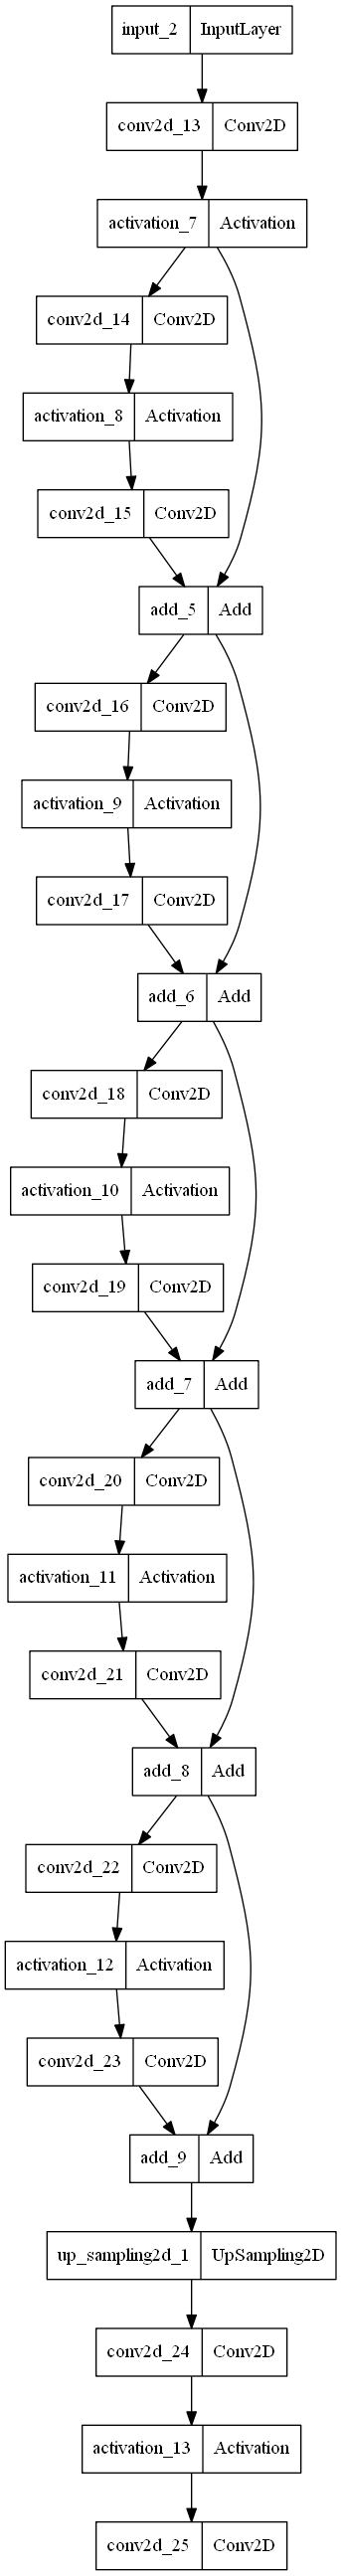

In [36]:
import keras
import tensorflow as tf
tf.keras.utils.plot_model(Wazir_model, 'Wazir_first1_model.png')

In [37]:
def randomHorizontalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 1)
    return img
def randomVerticalFlip(img, u=0.5):
    if np.random.random() < u:
        img = cv2.flip(img, 0)
    return img

In [38]:
def randomCrop(img):
    global input_size
    h=input_size*2
    assert img.shape[0] >= h
    assert img.shape[1] >= h
    x = random.randint(0, img.shape[1] - h)
    y = random.randint(0, img.shape[0] - h)
    img = img[y:y+h, x:x+h]
    return img

In [39]:
def train_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(train_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(train_list))
            ids_train_batch = train_list[start:end]
            for i,ids in enumerate(ids_train_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                tar = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)  #####
                tar = randomHorizontalFlip(tar)
                tar = randomVerticalFlip(tar)
                img1 = cv2.resize(tar, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(tar)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

# i am using Set5 dataset for validation please download the data
def valid_generator():
    global batch_size
    global input_size
    while True:
        for start in range(0, len(val_list), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(val_list))
            ids_valid_batch = val_list[start:end]            
            for i,ids in enumerate(ids_valid_batch):
                img = cv2.imread(ids)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img1 = cv2.resize(img, (input_size, input_size),interpolation=cv2.INTER_CUBIC)
                img2 = cv2.resize(img, (input_size*2, input_size*2),interpolation=cv2.INTER_CUBIC)
                x_batch.append(img1)
                y_batch.append(img2)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.float32) / 255.
            yield x_batch, y_batch

In [40]:
l=next(valid_generator())

In [ ]:
def wazir_loss(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [41]:
def psnr(y_true,y_pred):
    return tf.image.psnr(y_true,y_pred,1.0)
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)
def mean_squared_error(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true, y_pred)

In [42]:
learning_rate=0.001
adam=K.optimizers.Adam(lr=learning_rate)
Wazir_model.compile(optimizer=adam,loss='mse',metrics=[psnr,ssim,mean_squared_error])

In [43]:
def fit(model,epoch=5):
    model.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=epoch,
                    verbose=1,
                    validation_data=valid_generator(),
                    shuffle=True,
                    validation_steps=np.ceil(float(len(val_list)) / float(batch_size)))
    return model

In [ ]:
Wazir_model=fit(Wazir_model,1000)

Epoch 1/1000
6/6 [==============================] - 0s 27ms/step - loss: 0.0059 - psnr: 23.8853 - ssim: 0.7820 - mean_squared_error: 0.0059 - val_loss: 0.0127 - val_psnr: 20.1303 - val_ssim: 0.7082 - val_mean_squared_error: 0.0127


C:\Users\user\AppData\Local\Temp/ipykernel_13304/3857440714.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator(),


Epoch 2/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0059 - psnr: 23.8205 - ssim: 0.7791 - mean_squared_error: 0.0059 - val_loss: 0.0128 - val_psnr: 20.1230 - val_ssim: 0.7143 - val_mean_squared_error: 0.0128
Epoch 3/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0059 - psnr: 23.8661 - ssim: 0.7770 - mean_squared_error: 0.0059 - val_loss: 0.0127 - val_psnr: 20.1879 - val_ssim: 0.7128 - val_mean_squared_error: 0.0127
Epoch 4/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0058 - psnr: 23.9519 - ssim: 0.7822 - mean_squared_error: 0.0058 - val_loss: 0.0127 - val_psnr: 20.1833 - val_ssim: 0.7134 - val_mean_squared_error: 0.0127
Epoch 5/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0058 - psnr: 24.0091 - ssim: 0.7847 - mean_squared_error: 0.0058 - val_loss: 0.0125 - val_psnr: 20.2274 - val_ssim: 0.7157 - val_mean_squared_error: 0.0125
Epoch 6/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0

6/6 [==============================] - 0s 30ms/step - loss: 0.0059 - psnr: 23.9760 - ssim: 0.7850 - mean_squared_error: 0.0059 - val_loss: 0.0128 - val_psnr: 20.1575 - val_ssim: 0.7104 - val_mean_squared_error: 0.0128
Epoch 73/1000
6/6 [==============================] - 0s 26ms/step - loss: 0.0059 - psnr: 23.9382 - ssim: 0.7820 - mean_squared_error: 0.0059 - val_loss: 0.0127 - val_psnr: 20.1702 - val_ssim: 0.7115 - val_mean_squared_error: 0.0127
Epoch 74/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0059 - psnr: 23.9748 - ssim: 0.7846 - mean_squared_error: 0.0059 - val_loss: 0.0127 - val_psnr: 20.1458 - val_ssim: 0.7164 - val_mean_squared_error: 0.0127
Epoch 75/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0059 - psnr: 23.9370 - ssim: 0.7847 - mean_squared_error: 0.0059 - val_loss: 0.0130 - val_psnr: 20.0832 - val_ssim: 0.7072 - val_mean_squared_error: 0.0130
Epoch 76/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0059 - psn

Epoch 107/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0058 - psnr: 24.0179 - ssim: 0.7860 - mean_squared_error: 0.0058 - val_loss: 0.0129 - val_psnr: 20.1498 - val_ssim: 0.7111 - val_mean_squared_error: 0.0129
Epoch 108/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0058 - psnr: 24.0463 - ssim: 0.7865 - mean_squared_error: 0.0058 - val_loss: 0.0127 - val_psnr: 20.1667 - val_ssim: 0.7148 - val_mean_squared_error: 0.0127
Epoch 109/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0058 - psnr: 24.0246 - ssim: 0.7865 - mean_squared_error: 0.0058 - val_loss: 0.0128 - val_psnr: 20.1698 - val_ssim: 0.7119 - val_mean_squared_error: 0.0128
Epoch 110/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0058 - psnr: 23.9500 - ssim: 0.7859 - mean_squared_error: 0.0058 - val_loss: 0.0126 - val_psnr: 20.1855 - val_ssim: 0.7163 - val_mean_squared_error: 0.0126
Epoch 111/1000
6/6 [==============================] - 0s 24ms/step -

6/6 [==============================] - 0s 22ms/step - loss: 0.0058 - psnr: 23.9275 - ssim: 0.7821 - mean_squared_error: 0.0058 - val_loss: 0.0129 - val_psnr: 20.1303 - val_ssim: 0.7142 - val_mean_squared_error: 0.0129
Epoch 178/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0058 - psnr: 23.9549 - ssim: 0.7804 - mean_squared_error: 0.0058 - val_loss: 0.0127 - val_psnr: 20.2018 - val_ssim: 0.7144 - val_mean_squared_error: 0.0127
Epoch 179/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0058 - psnr: 23.9858 - ssim: 0.7831 - mean_squared_error: 0.0058 - val_loss: 0.0130 - val_psnr: 20.1168 - val_ssim: 0.7093 - val_mean_squared_error: 0.0130
Epoch 180/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0058 - psnr: 23.9277 - ssim: 0.7798 - mean_squared_error: 0.0058 - val_loss: 0.0130 - val_psnr: 20.0574 - val_ssim: 0.7122 - val_mean_squared_error: 0.0130
Epoch 181/1000
6/6 [==============================] - 0s 33ms/step - loss: 0.0059 -

Epoch 247/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0057 - psnr: 24.0497 - ssim: 0.7858 - mean_squared_error: 0.0057 - val_loss: 0.0129 - val_psnr: 20.1158 - val_ssim: 0.7115 - val_mean_squared_error: 0.0129
Epoch 248/1000
6/6 [==============================] - 0s 28ms/step - loss: 0.0057 - psnr: 24.0490 - ssim: 0.7854 - mean_squared_error: 0.0057 - val_loss: 0.0128 - val_psnr: 20.1567 - val_ssim: 0.7133 - val_mean_squared_error: 0.0128
Epoch 249/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0057 - psnr: 24.1139 - ssim: 0.7855 - mean_squared_error: 0.0057 - val_loss: 0.0129 - val_psnr: 20.1332 - val_ssim: 0.7122 - val_mean_squared_error: 0.0129
Epoch 250/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0057 - psnr: 24.0874 - ssim: 0.7871 - mean_squared_error: 0.0057 - val_loss: 0.0129 - val_psnr: 20.1177 - val_ssim: 0.7106 - val_mean_squared_error: 0.0129
Epoch 251/1000
6/6 [==============================] - 0s 23ms/step -

Epoch 282/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0057 - psnr: 24.0776 - ssim: 0.7850 - mean_squared_error: 0.0057 - val_loss: 0.0128 - val_psnr: 20.1731 - val_ssim: 0.7124 - val_mean_squared_error: 0.0128
Epoch 283/1000
6/6 [==============================] - 0s 27ms/step - loss: 0.0057 - psnr: 24.0627 - ssim: 0.7861 - mean_squared_error: 0.0057 - val_loss: 0.0130 - val_psnr: 20.1308 - val_ssim: 0.7119 - val_mean_squared_error: 0.0130
Epoch 284/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0057 - psnr: 24.1033 - ssim: 0.7864 - mean_squared_error: 0.0057 - val_loss: 0.0128 - val_psnr: 20.1576 - val_ssim: 0.7140 - val_mean_squared_error: 0.0128
Epoch 285/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0057 - psnr: 24.1020 - ssim: 0.7880 - mean_squared_error: 0.0057 - val_loss: 0.0128 - val_psnr: 20.1746 - val_ssim: 0.7123 - val_mean_squared_error: 0.0128
Epoch 286/1000
6/6 [==============================] - 0s 23ms/step -

6/6 [==============================] - 0s 24ms/step - loss: 0.0057 - psnr: 24.0729 - ssim: 0.7863 - mean_squared_error: 0.0057 - val_loss: 0.0130 - val_psnr: 20.0970 - val_ssim: 0.7128 - val_mean_squared_error: 0.0130
Epoch 353/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0057 - psnr: 24.1057 - ssim: 0.7862 - mean_squared_error: 0.0057 - val_loss: 0.0131 - val_psnr: 20.1218 - val_ssim: 0.7110 - val_mean_squared_error: 0.0131
Epoch 354/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0057 - psnr: 24.0866 - ssim: 0.7861 - mean_squared_error: 0.0057 - val_loss: 0.0128 - val_psnr: 20.1625 - val_ssim: 0.7121 - val_mean_squared_error: 0.0128
Epoch 355/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0057 - psnr: 24.0491 - ssim: 0.7844 - mean_squared_error: 0.0057 - val_loss: 0.0129 - val_psnr: 20.1262 - val_ssim: 0.7128 - val_mean_squared_error: 0.0129
Epoch 356/1000
6/6 [==============================] - 0s 23ms/step - loss: 0.0057 -

Epoch 387/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0057 - psnr: 23.9951 - ssim: 0.7837 - mean_squared_error: 0.0057 - val_loss: 0.0131 - val_psnr: 20.1078 - val_ssim: 0.7108 - val_mean_squared_error: 0.0131
Epoch 388/1000
6/6 [==============================] - 0s 24ms/step - loss: 0.0057 - psnr: 24.0813 - ssim: 0.7864 - mean_squared_error: 0.0057 - val_loss: 0.0129 - val_psnr: 20.1424 - val_ssim: 0.7115 - val_mean_squared_error: 0.0129
Epoch 389/1000
6/6 [==============================] - ETA: 0s - loss: 0.0055 - psnr: 24.3303 - ssim: 0.7892 - mean_squared_error: 0.005 - 0s 24ms/step - loss: 0.0057 - psnr: 24.1203 - ssim: 0.7887 - mean_squared_error: 0.0057 - val_loss: 0.0129 - val_psnr: 20.1397 - val_ssim: 0.7144 - val_mean_squared_error: 0.0129
Epoch 390/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0057 - psnr: 24.0603 - ssim: 0.7880 - mean_squared_error: 0.0057 - val_loss: 0.0131 - val_psnr: 20.0965 - val_ssim: 0.7106 - val_mean_square